# HW2

# Importing stuff

In [127]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
import os
import pickle
from collections import OrderedDict, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from redditscore.tokenizer import CrazyTokenizer
from tqdm import tqdm_notebook

import data_utils
import models
import training_utils
from sklearn import metrics
from sklearn.model_selection import ParameterGrid, train_test_split

In [129]:
import matplotlib.pyplot as plt
import seaborn
from jupyterthemes import jtplot

jtplot.style()

In [130]:
SEED = 24

if torch.cuda.is_available and torch.has_cudnn:
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device("cpu")

# Preparing data

In [131]:
train = pd.read_table('data/snli_train.tsv')
val = pd.read_table('data/snli_val.tsv')

Split sentences into tokens

In [132]:
train_tokens1, train_tokens2 = data_utils.tokenize_dataset(train)
train_labels = list(train.label)

val_tokens1, val_tokens2 = data_utils.tokenize_dataset(val)
val_labels = list(val.label)

Set some constant parameters

In [133]:
MAX_VOCAB_SIZE = 30000
EMBED_SIZE = 300
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 64
MAX_SENT_LENGTH = 70
NUM_CLASSES = 3

Read fastText word vectors

In [134]:
ft_embeddings = KeyedVectors.load_word2vec_format('data/wiki-news-300d-1M.vec')

Generate vocabulary

In [135]:
token2id, id2token = data_utils.build_vocab(train_tokens1 + train_tokens2, ft_embeddings)

Fill embedding matrix

In [136]:
init_embeddings = np.zeros((len(token2id), EMBED_SIZE))

In [137]:
for token, id_ in token2id.items():
    if token in ft_embeddings:
        init_embeddings[id_] = ft_embeddings[token]
    elif token == '<unk>':
        init_embeddings[id_] = np.random.normal(size=(300, ))
    elif token == '<pad>':
        init_embeddings[id_] = np.zeros(300)

Initialize data loaders

In [138]:
train_dataset = data_utils.TextDataset(train_tokens1, train_tokens2, train_labels, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_utils.text_collate_func,
                                           shuffle=True)

val_dataset = data_utils.TextDataset(val_tokens1, val_tokens2, val_labels, token2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=data_utils.text_collate_func,
                                           shuffle=True)

In [139]:
del ft_embeddings

# Training models

In [142]:
lr = 1e-4
num_epochs = 10000
patience = 5
criterion = torch.nn.CrossEntropyLoss()

## CNN tuning

In [41]:
pars = {'kernel_size': [3, 5, 7],
        'hidden_size': [64, 128, 256, 512],
        'dropout': [0.0, 0.5]}
param_grid = ParameterGrid(pars)

In [44]:
best_losses_cnn = pd.DataFrame(columns=['parameters', 'val_loss', 'val_acc'])
best_losses_cnn['parameters'] = list(param_grid)
for i, params in enumerate(tqdm_notebook(param_grid, desc='grid_search')):
    cnn_encoder = models.CNNEncoder(
        EMBED_SIZE,
        params['hidden_size'],
        len(token2id),
        PAD_IDX,
        params['kernel_size'],
        init_embeddings).to(DEVICE)
    cnn_model = models.InferenceModel(
        cnn_encoder,
        NUM_CLASSES,
        params['hidden_size'] * 2,
        dropout=params['dropout']).to(DEVICE)
    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)

    best_val_loss = np.inf
    counter = 0
    for epoch in tqdm_notebook(range(100000), desc='epoch'):
        if counter > patience:
            print('Early stopping')
            break
        loss_train = training_utils.train_model(cnn_model, cnn_optimizer,
                                                train_loader, criterion)
        loss_val, ys_hat, ys = training_utils.eval_model(
            cnn_model, val_loader, criterion)
        acc = metrics.accuracy_score(ys, ys_hat.argmax(axis=1))
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            best_acc = acc
            counter = 0
        else:
            counter += 1
    best_losses_cnn.loc[i, 'val_loss'] = best_val_loss
    best_losses_cnn.loc[i, 'val_acc'] = best_acc
    
    # need to subtract parameters that are not actually trainable
    best_losses_cnn.loc[i, 'total_params'] = sum(
        p.numel() for p in cnn_model.parameters()
        if p.requires_grad) - (len(token2id) - 1) * EMBED_SIZE

    print(best_losses_cnn.head(i + 1))

Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657


Early stopping
                                          parameters  val_loss val_acc
0  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2  {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5  {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8  {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663


Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669


Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678


Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

Early stopping
                                           parameters  val_loss val_acc
0   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.792253   0.653
1   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.781188    0.66
2   {'dropout': 0.0, 'hidden_size': 64, 'kernel_si...  0.782115   0.657
3   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.781131   0.658
4   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...  0.788944   0.655
5   {'dropout': 0.0, 'hidden_size': 128, 'kernel_s...   0.78645   0.669
6   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.767499   0.664
7   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...   0.77422   0.672
8   {'dropout': 0.0, 'hidden_size': 256, 'kernel_s...  0.793024   0.657
9   {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.776088   0.663
10  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.763643   0.669
11  {'dropout': 0.0, 'hidden_size': 512, 'kernel_s...  0.771516   0.678
12  {'dropout': 0.5, 'hidden_size': 64, 'kernel_s

In [72]:
best_losses_cnn['val_loss'] = pd.to_numeric(best_losses_cnn['val_loss'])
best_losses_cnn['val_acc'] = pd.to_numeric(best_losses_cnn['val_acc'])
best_losses_cnn = best_losses_cnn.round(3)

In [79]:
best_losses_cnn = pd.concat([
    best_losses_cnn['parameters'].apply(pd.Series),
    best_losses_cnn.drop('parameters', axis=1)
], axis=1)

In [80]:
print(best_losses_cnn.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 dropout &  hidden\_size &  kernel\_size &  val\_loss &  val\_acc &  total\_params \\
\midrule
     0.0 &         64.0 &          3.0 &     0.792 &    0.653 &       87215.0 \\
     0.0 &         64.0 &          5.0 &     0.781 &    0.660 &      133807.0 \\
     0.0 &         64.0 &          7.0 &     0.782 &    0.657 &      180399.0 \\
     0.0 &        128.0 &          3.0 &     0.781 &    0.658 &      231471.0 \\
     0.0 &        128.0 &          5.0 &     0.789 &    0.655 &      341039.0 \\
     0.0 &        128.0 &          7.0 &     0.786 &    0.669 &      450607.0 \\
     0.0 &        256.0 &          3.0 &     0.767 &    0.664 &      692015.0 \\
     0.0 &        256.0 &          5.0 &     0.774 &    0.672 &      976687.0 \\
     0.0 &        256.0 &          7.0 &     0.793 &    0.657 &     1261359.0 \\
     0.0 &        512.0 &          3.0 &     0.776 &    0.663 &     2301231.0 \\
     0.0 &        512.0 &          5.0 &     0.764 &    0.669 

## RNN tuning

In [83]:
pars = {'hidden_size': [64, 128, 256, 512],
        'dropout': [0.0, 0.5]}
param_grid = ParameterGrid(pars)
lr = 1e-3

In [84]:
best_losses_rnn = pd.DataFrame(columns=['parameters', 'val_loss', 'val_acc'])
best_losses_rnn['parameters'] = list(param_grid)
for i, params in enumerate(tqdm_notebook(param_grid, desc='grid_search')):
    rnn_encoder = models.RNNEncoder(
        EMBED_SIZE,
        params['hidden_size'],
        len(token2id),
        PAD_IDX,
        init_embeddings).to(DEVICE)
    rnn_model = models.InferenceModel(
        rnn_encoder,
        NUM_CLASSES,
        params['hidden_size'] * 2,
        dropout=params['dropout']).to(DEVICE)
    rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr)

    best_val_loss = np.inf
    counter = 0
    for epoch in tqdm_notebook(range(100000), desc='epoch'):
        if counter > patience:
            print('Early stopping')
            break
        loss_train = training_utils.train_model(rnn_model, rnn_optimizer,
                                                train_loader, criterion)
        loss_val, ys_hat, ys = training_utils.eval_model(
            rnn_model, val_loader, criterion)
        acc = metrics.accuracy_score(ys, ys_hat.argmax(axis=1))
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            best_acc = acc
            counter = 0
        else:
            counter += 1
    best_losses_rnn.loc[i, 'val_loss'] = best_val_loss
    best_losses_rnn.loc[i, 'val_acc'] = best_acc
    best_losses_rnn.loc[i, 'total_params'] = sum(
        p.numel() for p in rnn_model.parameters()
        if p.requires_grad) - (len(token2id) - 1) * EMBED_SIZE

    print(best_losses_rnn.head(i + 1))

Early stopping
                            parameters  val_loss val_acc  total_params
0  {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0
3  {'dropout': 0.0, 'hidden_size': 512}  0.678859   0.719     3553583.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0
3  {'dropout': 0.0, 'hidden_size': 512}  0.678859   0.719     3553583.0
4   {'dropout': 0.5, 'hidden_size': 64}   0.71004    0.71      157743.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0
3  {'dropout': 0.0, 'hidden_size': 512}  0.678859   0.719     3553583.0
4   {'dropout': 0.5, 'hidden_size': 64}   0.71004    0.71      157743.0
5  {'dropout': 0.5, 'hidden_size': 128}  0.694251   0.714      397103.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0
3  {'dropout': 0.0, 'hidden_size': 512}  0.678859   0.719     3553583.0
4   {'dropout': 0.5, 'hidden_size': 64}   0.71004    0.71      157743.0
5  {'dropout': 0.5, 'hidden_size': 128}  0.694251   0.714      397103.0
6  {'dropout': 0.5, 'hidden_size': 256}  0.688791   0.714     1121583.0


Early stopping
                             parameters  val_loss val_acc  total_params
0   {'dropout': 0.0, 'hidden_size': 64}  0.704393   0.702      157743.0
1  {'dropout': 0.0, 'hidden_size': 128}  0.692307   0.715      397103.0
2  {'dropout': 0.0, 'hidden_size': 256}  0.689424   0.705     1121583.0
3  {'dropout': 0.0, 'hidden_size': 512}  0.678859   0.719     3553583.0
4   {'dropout': 0.5, 'hidden_size': 64}   0.71004    0.71      157743.0
5  {'dropout': 0.5, 'hidden_size': 128}  0.694251   0.714      397103.0
6  {'dropout': 0.5, 'hidden_size': 256}  0.688791   0.714     1121583.0
7  {'dropout': 0.5, 'hidden_size': 512}  0.711472   0.698     3553583.0


In [85]:
best_losses_rnn['val_loss'] = pd.to_numeric(best_losses_rnn['val_loss'])
best_losses_rnn['val_acc'] = pd.to_numeric(best_losses_rnn['val_acc'])
best_losses_rnn = best_losses_rnn.round(3)

In [86]:
best_losses_rnn = pd.concat([
    best_losses_rnn['parameters'].apply(pd.Series),
    best_losses_rnn.drop('parameters', axis=1)
], axis=1)

In [87]:
print(best_losses_rnn.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 dropout &  hidden\_size &  val\_loss &  val\_acc &  total\_params \\
\midrule
     0.0 &         64.0 &     0.704 &    0.702 &      157743.0 \\
     0.0 &        128.0 &     0.692 &    0.715 &      397103.0 \\
     0.0 &        256.0 &     0.689 &    0.705 &     1121583.0 \\
     0.0 &        512.0 &     0.679 &    0.719 &     3553583.0 \\
     0.5 &         64.0 &     0.710 &    0.710 &      157743.0 \\
     0.5 &        128.0 &     0.694 &    0.714 &      397103.0 \\
     0.5 &        256.0 &     0.689 &    0.714 &     1121583.0 \\
     0.5 &        512.0 &     0.711 &    0.698 &     3553583.0 \\
\bottomrule
\end{tabular}



# Retraining best models

In [143]:
cnn_train_losses = []
cnn_val_losses = []
cnn_encoder = models.CNNEncoder(
    EMBED_SIZE,
    512,
    len(token2id),
    PAD_IDX,
    3,
    init_embeddings).to(DEVICE)
cnn_model = models.InferenceModel(
    cnn_encoder,
    NUM_CLASSES,
    params['hidden_size'] * 2,
    dropout=0.5).to(DEVICE)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

best_val_loss = np.inf
counter = 0
for epoch in tqdm_notebook(range(100000), desc='epoch'):
    if counter > patience:
        print('Early stopping')
        break
    loss_train = training_utils.train_model(cnn_model, cnn_optimizer,
                                            train_loader, criterion)
    loss_val, ys_hat, ys = training_utils.eval_model(
        cnn_model, val_loader, criterion)
    cnn_train_losses.append(loss_train)
    cnn_val_losses.append(loss_val)
    
    if loss_val < best_val_loss:
            best_val_loss = loss_val
            best_acc = acc
            counter = 0
    else:
        counter += 1

Early stopping


In [144]:
rnn_train_losses = []
rnn_val_losses = []
rnn_encoder = models.RNNEncoder(
    EMBED_SIZE,
    512,
    len(token2id),
    PAD_IDX,
    init_embeddings).to(DEVICE)
rnn_model = models.InferenceModel(
    rnn_encoder,
    NUM_CLASSES,
    params['hidden_size'] * 2,
    dropout=0.0).to(DEVICE)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)

best_val_loss = np.inf
counter = 0
for epoch in tqdm_notebook(range(100000), desc='epoch'):
    if counter > patience:
        print('Early stopping')
        break
    loss_train = training_utils.train_model(rnn_model, rnn_optimizer,
                                            train_loader, criterion)
    loss_val, ys_hat, ys = training_utils.eval_model(
        rnn_model, val_loader, criterion)
    rnn_train_losses.append(loss_train)
    rnn_val_losses.append(loss_val)
    
    if loss_val < best_val_loss:
            best_val_loss = loss_val
            best_acc = acc
            counter = 0
    else:
        counter += 1

Early stopping


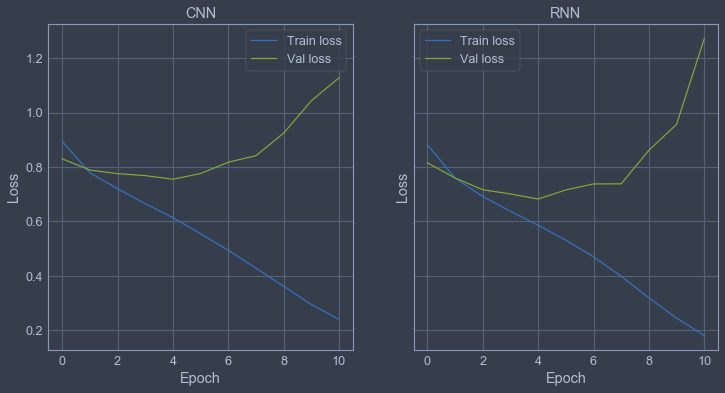

In [148]:
fig,ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].plot(cnn_train_losses, label='Train loss')
ax[0].plot(cnn_val_losses, label='Val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('CNN')
ax[0].legend(loc='best')
ax[1].plot(rnn_train_losses, label='Train loss')
ax[1].plot(rnn_val_losses, label='Val loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('RNN')
ax[1].legend(loc='best')
plt.savefig('trval.png', bbox_inches='tight')

In [149]:
torch.save(cnn_model.state_dict(), 'cnn_weights.p')
torch.save(rnn_model.state_dict(), 'rnn_weights.p')

# MultiNLI

In [150]:
train_m = pd.read_table('data/mnli_train.tsv')
val_m = pd.read_table('data/mnli_val.tsv')
genres = list(train_m.genre.unique())

In [151]:
train_m.head(5)

,sentence1,sentence2,label,genre
0,and now that was in fifty one that 's forty ye...,It was already a problem forty years ago but n...,neutral,telephone
1,Jon could smell baked bread on the air and his...,Jon smelt food in the air and was hungry .,neutral,fiction
2,it will be like Italian basketball with the uh...,This type of Italian basketball is nothing lik...,contradiction,telephone
3,well i think that 's about uh that 's about co...,Sorry but we are not done just yet .,contradiction,telephone
4,"Good job tenure , that is -- because in yet an...","Dr. Quinn , Medicine Woman , was worked on by ...",entailment,slate


In [160]:
mlni_results = pd.DataFrame(
    columns=['CNN_acc', 'CNN_tuned_acc', 'RNN_acc', 'RNN_tuned_acc'],
    index=genres)
tuning_epochs = 3
for genre in genres:
    train_genre = train_m.loc[train_m.genre == genre].copy()
    val_genre = val_m.loc[val_m.genre == genre].copy()

    train_tokens1, train_tokens2 = data_utils.tokenize_dataset(train_genre)
    train_labels = list(train_genre.label)

    val_tokens1, val_tokens2 = data_utils.tokenize_dataset(val_genre)
    val_labels = list(val_genre.label)

    train_dataset = data_utils.TextDataset(train_tokens1, train_tokens2,
                                           train_labels, token2id)
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        collate_fn=data_utils.text_collate_func,
        shuffle=True)

    val_dataset = data_utils.TextDataset(val_tokens1, val_tokens2, val_labels,
                                         token2id)
    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        collate_fn=data_utils.text_collate_func,
        shuffle=True)

    cnn_encoder = models.CNNEncoder(EMBED_SIZE, 512, len(token2id), PAD_IDX, 3,
                                    init_embeddings).to(DEVICE)
    rnn_encoder = models.RNNEncoder(EMBED_SIZE, 512, len(token2id), PAD_IDX,
                                    init_embeddings).to(DEVICE)
    cnn_model = models.InferenceModel(
        cnn_encoder, NUM_CLASSES, 1024, dropout=0.5).to(DEVICE)
    rnn_model = models.InferenceModel(
        rnn_encoder, NUM_CLASSES, 1024, dropout=0.0).to(DEVICE)

    cnn_model.load_state_dict(torch.load('cnn_weights.p'))
    rnn_model.load_state_dict(torch.load('rnn_weights.p'))

    for param in cnn_model.encoder.embedding.parameters():
        param.requires_grad = False
    for param in rnn_model.encoder.embedding.parameters():
        param.requires_grad = False

    cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-5)
    rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)

    _, ys_hat, ys = training_utils.eval_model(cnn_model, val_loader, criterion)
    mlni_results.loc[genre, 'CNN_acc'] = metrics.accuracy_score(
        ys, ys_hat.argmax(axis=1))

    _, ys_hat, ys = training_utils.eval_model(rnn_model, val_loader, criterion)
    mlni_results.loc[genre, 'RNN_acc'] = metrics.accuracy_score(
        ys, ys_hat.argmax(axis=1))

    for epoch in tqdm_notebook(range(tuning_epochs), desc='epoch'):
        training_utils.train_model(
            cnn_model, cnn_optimizer, train_loader, criterion, zero_grad=False)
        training_utils.train_model(
            rnn_model, rnn_optimizer, train_loader, criterion, zero_grad=False)

    _, ys_hat, ys = training_utils.eval_model(cnn_model, val_loader, criterion)
    mlni_results.loc[genre, 'CNN_tuned_acc'] = metrics.accuracy_score(
        ys, ys_hat.argmax(axis=1))

    _, ys_hat, ys = training_utils.eval_model(rnn_model, val_loader, criterion)
    mlni_results.loc[genre, 'RNN_tuned_acc'] = metrics.accuracy_score(
        ys, ys_hat.argmax(axis=1))

In [169]:
mlni_results = mlni_results.apply(pd.to_numeric, axis=1).round(3)

In [170]:
print(mlni_results.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  CNN\_acc &  CNN\_tuned\_acc &  RNN\_acc &  RNN\_tuned\_acc \\
\midrule
telephone  &    0.422 &          0.450 &    0.456 &          0.482 \\
fiction    &    0.403 &          0.449 &    0.464 &          0.484 \\
slate      &    0.421 &          0.412 &    0.442 &          0.445 \\
government &    0.440 &          0.466 &    0.430 &          0.489 \\
travel     &    0.423 &          0.448 &    0.439 &          0.474 \\
\bottomrule
\end{tabular}

